# INFR 3700U Assignment 2 Fall 2024

This notebook contains the questions for Assignment 2. Make sure to complete this assignment individually and appropriately reference all external code and documentation used. ***You must upload this completed Jupyter Notebook file as your submission (other file types are not permitted and will result in a grade of 0).***

* If you have trouble running neural network models on your laptop, you can use online platforms, like **[Google Colab](https://colab.research.google.com/)**.
* All Figures should have a x- and y-axis label and an appropriate title.
**Ensure that your code runs correctly by choosing "Kernel -> Restart and Cell -> Run All" before submitting.**

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input
import tensorflow as tf

import time

#add other imports here (if any, for example, pytorch)
from tensorflow.keras.optimizers import SGD

## Data set
As modern vehicles have lots of connectivity, protecting in-vehicle network from cyber-attacks is an important issue. Controller Area Network (CAN) is the standard protocol for the in-vehicle network. But, the lack of security features in the CAN protocol makes vehicles vulnerable to attacks. The message injection attack is a representative attack type which injects fabricated messages to deceive electronic control unit (ECUs) or cause malfunctions. Through this notebook, you will develop ML/DL modules to detect different types of CAN attacks and protect vehicle networks.

### Source
The dataset (CAN-intrusion-dataset-10000.csv) has been constructed by logging CAN traffic via the OBD-II port from a real vehicle while message injection attacks were performing. The classification goal is to distinguish cyber-attacks and normal samples by classifying the data samples. The dataset includes over 10,000 records and 10 attributes (including the target variable "Label").

### Variables
The definitions of the attributes are as followss.

* CAN ID : identifier of CAN message.
* DATA[0~7] : data value (byte), ranging from 0 to 255. They have been converted from hexadecimal numbers to decimal numbers.  
* Label : 0 indicates 'Normal', and 1 indicates an attack (including DoS, Fuzzy, Gear, or RPM).

## Question 1: Load Datasets (15pts)
A) Load the Data set CAN-intrusion-dataset-10000.csv

B) Split the data into equals-sized training and test sets (use a random_state = 1, and do not shuffle the data).  

C) How many observations do you have in your training set?  

D) How many observations for each class in your training set?

E) Z-standarize the input features of the training and test sets.

In [2]:
### Q1A)

#Loading the Data
myData=pd.read_csv('CAN-intrusion-dataset-10000.csv')

In [3]:
### Q1B)

#Setting the features (everything except Label)
X = myData.drop(columns='Label')
#Setting the target variable (Label)
y = myData['Label']

#Data Splitting with training set and test set at 50% each
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.50, random_state = 1)


In [4]:
### Q1C)

#Printing the observations in the training set
print(f'Training data shape: {X_train.shape[0]}, Training labels shape: {y_train.shape[0]}')

Training data shape: 5000, Training labels shape: 5000


In [5]:
### Q1D)

#Counting the number of 0's and 1's in the y_train part of the data
observations = y_train.value_counts()

#Printing the observations in each class (0,1)
print(f'Number of observations in each class (0:normal) (1:attack):\n{observations}')

Number of observations in each class (0:normal) (1:attack):
Label
0    4262
1     738
Name: count, dtype: int64


In [6]:
### Q1E)

#To standardize the features
scaler = StandardScaler()

#fit scaler to the training set features
scaler.fit(X_train)

#scale the training and test set features using the transform method
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Question 2: Random Forest (20pts)
A) Apply a Random Forest model that consists of 10 base decision trees for classifying the events as normal or anomalous. Fill in the myRandomForest function, which accepts as input the training set and returns a fully trained model.

B) Call the funcion from 2A, and evaluate the performance of your models using 3 metrics of `Recall`, `Preceision` and `f1 score`. Additionally, print out the confusion matrix of your three models on the test set. Lastly, print-out the model training time (only training, do not including testing time).

C) Based on the trained Random Forest model, use a horizontal bar plot to plot the feature importance scores of all features (CAN_ID, DATA_0-DATA_7).

In [7]:
### Q2A)

#This function takes Xtrain and ytrain as parameters and creates a random forest model with 10 trees and returns a trained model
def myRandomForest(Xtrain, ytrain):
    myRandomForestModel = RandomForestClassifier(n_estimators=10)
    myRandomForestModel.fit(X_train,y_train)
    return myRandomForestModel

In [8]:
### Q2B)

#Time the model training time
start=time.time()
#Call the funcion from 2A a
rf = myRandomForest(X_train,y_train)
stop=time.time()

#Predicting the test to evaluate performance
y_pred_test = rf.predict(X_test)

#Performance of Recall
calculated_recall = recall_score(y_test, y_pred_test)

#Performance of Preceision
calculated_precision = precision_score(y_test, y_pred_test)

#Performance of f1 score
calculated_f1 = f1_score(y_test, y_pred_test)

#print out the confusion matrix of your three models on the test set
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()

training_time=stop-start

#print-out the performance and time
print("Preceision: ",calculated_precision)
print("F1 Score: ",calculated_f1)
print("Preceision: ",calculated_precision)
print("The confusion matrix function returned:\nTrue Negatives:\t\t{0}\nTrue Positives:\t\t{1}\nFalse Negatives:\t{2}\nFalse Positives:\t{3}\n".format(tn,tp,fn,fp))
print("Training Time: ", format(training_time, '.2f'))


Preceision:  1.0
F1 Score:  0.9992663242846662
Preceision:  1.0
The confusion matrix function returned:
True Negatives:		4318
True Positives:		681
False Negatives:	1
False Positives:	0

Training Time:  0.08


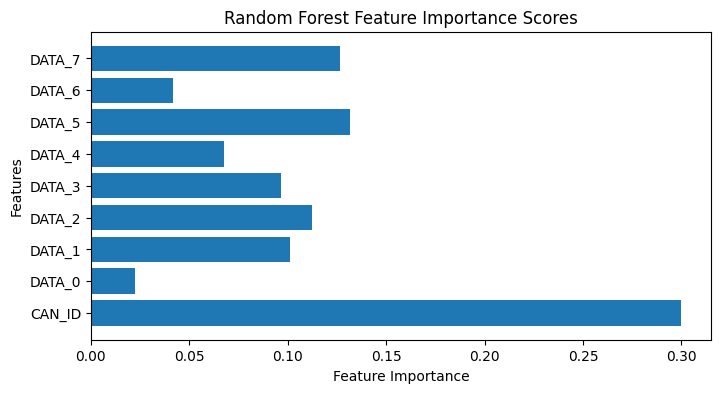

In [9]:
### Q2C)

#Get the feature names from the columns
feature_names = X.columns
importances = rf.feature_importances_

#Plot graph
plt.figure(figsize=(8, 4))
#Horizontal bar graph with features importance in the x axis and features in the y-axis
plt.barh(feature_names, importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance Scores')
plt.show()

## Question 3: Single Layer Neural Networks (30 pts)
In this task we aim to build models with better performance, using "deep" learning. __You can use Keras library for building deep learning models.__

A) Implement a single-layer neural network model that is used to classify the CAN intrusion data samples into normal and anomalous classes (0: normal, 1: attack). Use the standarized training set from Q1E) to train the network.

The details of the model are as follows:
* Use a Sigmoid as the output layer acitivation function to enable non-linearity.
* Use the binary cross-entropy loss as a training criterion.
* Use Stochastic gradient descent optimizer with a learning rate of 0.1.
* Run the model for 10 iterations/epochs.

B) Record the loss for each iteration, and make a plot of iterations/epochs vs loss(Binary Cross Entropy).

C) Print out the precision, recall, and F1-score of the test set.

D) Print out the model execution time (including both training and testing time) in milliseconds. Please keep two decimal places.

In [10]:
### Q3A)

#Single layer neural network
model = Sequential()
#Output layer with input shape be the number of features
model.add(Dense(1, input_shape=(X_train_scaled.shape[1],), activation = 'sigmoid'))

#compile the model using Stochastic gradient descent with learning rate of 0.1 and using binary crossentropy as the loss
model.compile(optimizer = SGD(learning_rate=0.1), loss='binary_crossentropy')

#training time for 3D
train_start=time.time()
#fit the model and run it 10 iteration and print it (verbose)
history =model.fit(X_train_scaled, y_train, epochs = 10, verbose=1)
train_stop=time.time()

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5137
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3267
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3144
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2914
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2916
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3053
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2795
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3012
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2983
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2886


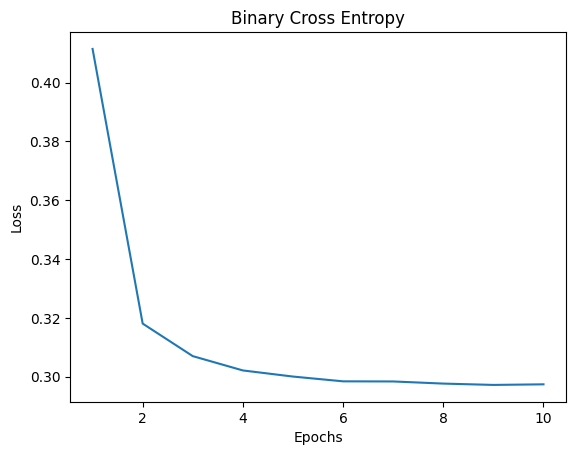

In [11]:
### Q3B)
#Get the loss values from each Epochs ran in 3A
loss = history.history['loss']

#Graph with epoch 1-10 in the x-axis and thier loss values in the y-axis
plt.plot(range(1, 11), loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Binary Cross Entropy')
plt.show()

In [12]:
### Q3C)

#Testing time for 3D
test_start=time.time()
#Print out the precision, recall, and F1-score of the test set
y_pred_test = model.predict(X_test_scaled)
test_stop=time.time()

#Using round on y_pred_test to keep the values either 0,1
#Performance of Recall
calculated_recall = recall_score(y_test, y_pred_test.round())

#Performance of Preceision
calculated_precision = precision_score(y_test, y_pred_test.round())

#Performance of f1 score
calculated_f1 = f1_score(y_test, y_pred_test.round())

#Printing performance
print("Recall: ",calculated_recall)
print("Preceision: ",calculated_precision)
print("F1 Score: ",calculated_f1)


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Recall:  0.5909090909090909
Preceision:  0.8975501113585747
F1 Score:  0.7126436781609196


In [13]:
#### Q3D)

#get execution time from training time and testing time
train_time=train_stop-train_start
test_time=test_stop-test_start
exec_time= train_time+test_time

#Print execution time
print("Execution Time: ", format(exec_time, '.2f'))

Execution Time:  10.77


## Question 4: Multi-Layer Perceptron (MLP) (35 pts)

A) Implement a Multi-Layer Perceptron (MLP) model (three hidden layers) that is used to classify the CAN intrusion data samples into normal and anomalous classes (0: normal, 1: attack). Use the standarized training set from Q1E) to train the network.
The details of the model are as follows:
* Each hidden layer have 8 neurons/units.
* Use tanh function as the activation function for hidden layers.
* Use a Sigmoid as the output layer acitivation function to enable non-linearity.  
* Use Stochastic gradient descent optimizer with a learning rate of 0.1.
* Run the model for 10 iterations/epochs

B) Record the loss for each iteration, and make a plot of iterations/epochs vs loss(Binary Cross Entropy).

C) Print out the precision, recall, and F1-score of the test set.

D) Print out the model execution time (including both training and testing time) in milliseconds. Please keep two decimal places.

E) Written Answer - Use the markdown cell to answer the following:
- Compare the performance and execution time of your single layer neural network to the MLP model, and discuss the reasons.

In [14]:
### Q4A)

model = Sequential()
#Hidden Layer 1 with 8 neurons using tanh as activation function
model.add(Dense(8, input_shape=(X_train_scaled.shape[1],), activation = 'tanh'))
#Hidden Layer 2 with 8 neurons using tanh as activation function
model.add(Dense(8, activation='tanh'))
#Hidden Layer 3 with 8 neurons using tanh as activation function
model.add(Dense(8, activation='tanh'))
#Output Layer with 1 neuron using sigmoid as activation function
model.add(Dense(1, activation='sigmoid'))

#compile the model using Stochastic gradient descent with learning rate of 0.1
#assuming binary crossentropy is the loss as 4b asks to plot that
model.compile(optimizer = SGD(learning_rate=0.1), loss='binary_crossentropy')

#Training time for 4D
train_start=time.time()
#fit the model and run it 10 iteration and print it (verbose)
history =model.fit(X_train_scaled, y_train, epochs = 10, verbose=1)
train_stop=time.time()



Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3713
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2069
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1326
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1082
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0755
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0588
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0369
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0381
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0384
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0395


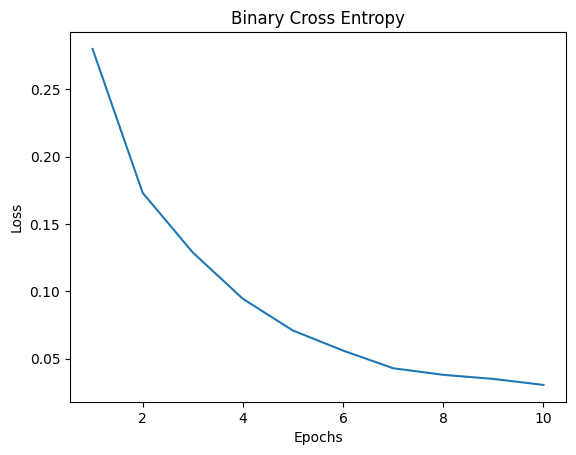

In [15]:
### Q4B)

#Get the loss values from each Epochs ran in 4A
loss = history.history['loss']

#Graph with epoch 1-10 in the x-axis and thier loss values in the y-axis
plt.plot(range(1, 11), loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Binary Cross Entropy')
plt.show()

In [16]:
### Q4C)

#Testing time for 4D
test_start=time.time()
#Print out the precision, recall, and F1-score of the test set
y_pred_test = model.predict(X_test_scaled)
test_stop=time.time()
#Using round on y_pred_test to keep the values either 0,1
#Performance of Recall
calculated_recall = recall_score(y_test, y_pred_test.round())

#Performance of Preceision
calculated_precision = precision_score(y_test, y_pred_test.round())

#Performance of f1 score
calculated_f1 = f1_score(y_test, y_pred_test.round())

#Prining performances
print("Recall: ",calculated_recall)
print("Preceision: ",calculated_precision)
print("F1 Score: ",calculated_f1)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Recall:  0.9882697947214076
Preceision:  0.9601139601139601
F1 Score:  0.9739884393063584


In [17]:
### Q4D)

#get execution time from training time and testing time
train_time=train_stop-train_start
test_time=test_stop-test_start
exec_time= train_time+test_time

#printing execution time
print("Execution Time: ", format(exec_time, '.2f'))

Execution Time:  12.49


#### Q4E)  

When comparing the performance and execution time of the single layer neural network and MLP model we see that the execution time of the single layer was 10.77 which was slightly better than MLP's 12.49. But when we compare performance the MLP dominates the single layer as its performance for preceision, recall, and f1 are above 95 where as single layer's preceision, recall, and f1 as all below 90%. I think that MLP performs far better with a slightly longer execution time.

## Question 5: Hyperparameter Optimization (10 Bonus pts)
A) Build a Random Forest model. Use grid search to tune two hyperparameters:
* The number of base decision trees (find the best number among 50, 100, 200).
* The maximum tree depth (find the best number among 10, 20).

Implement grid search to identify optimal hyperparameter values, and print out the best hyperparameter values and the best cross-validation accuracy.

You can use 3-fold GridSearchCV function on the standarized training set to do this.

B) Build the optimized Random Forest model on the standarized training set by using the detected best hyperparameter values. Print out the precision, recall, and F1-score of the optimized RF model on the standarized test set.


In [18]:
### Q5A)

In [19]:
### Q5B)

## Make sure to add sufficient comments to your code, and run the entire code before submitting.

Reference List

Cloud, S. (2023a, June 19). Python pandas convert valuecounts output to dataframe. Saturn Cloud Blog. https://saturncloud.io/blog/python-pandas-convert-valuecounts-output-to-dataframe/#:~:text=value_counts()%20method%20is%20a,count%20is%20the%20corresponding%20value.&text=As%20you%20can%20see%2C%20the%20output%20of%20
Cloud, S. (2023b, June 19). Python pandas convert valuecounts output to dataframe. Saturn Cloud Blog. https://saturncloud.io/blog/python-pandas-convert-valuecounts-output-to-dataframe/#:~:text=value_counts()%20method%20is%20a,count%20is%20the%20corresponding%20value.&text=As%20you%20can%20see%2C%20the%20output%20of%20
GeeksforGeeks. (2024a, April 5). Feature importance with random forests. GeeksforGeeks. https://www.geeksforgeeks.org/feature-importance-with-random-forests/
GeeksforGeeks. (2024b, June 28). How to get column names in Pandas. GeeksforGeeks. https://www.geeksforgeeks.org/how-to-get-column-names-in-pandas-dataframe/
ishido. (2024, February). How to return history of validation loss in Keras. Stack Overflow. https://stackoverflow.com/questions/36952763/how-to-return-history-of-validation-loss-in-keras
Keras documentation: Probabilistic losses. Keras. (n.d.-a). https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class
Kreiger, J. (2020, January 12). Evaluating a random forest model. Medium. https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56
Rahbek, O. (2020, August 17). How do you find the number of observations in a data set?. Quora. https://www.quora.com/How-do-you-find-the-number-of-observations-in-a-data-set
SEDIRI, A. (2016, June 24). Accuracy score ValueError: Can’t handle mix of binary and continuous target. Stack Overflow. https://stackoverflow.com/questions/38015181/accuracy-score-valueerror-cant-handle-mix-of-binary-and-continuous-target
SGD. Keras. (n.d.-b). https://keras.io/api/optimizers/sgd/